In [1]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet
import os
import json


import jobqueue
from jobqueue.connection_manager import ConnectionManager

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

import dmp.keras_interface.model_serialization as model_serialization
from dmp.task.experiment.training_experiment.training_epoch import TrainingEpoch

pd.options.display.max_seq_items = None

credentials = jobqueue.load_credentials("dmp")


2024-04-03 14:44:47.073177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from dataclasses import dataclass

@dataclass
class Column:
    name : str
    pandas_type : str


In [3]:
def getWeights(queue, runId, userName):
    # get the weights from the hpc
    # scp the weights from the hpc to the local machine
    hpc = ""
    location = f"/projects/modularai/dmp/dmp/model_data"
    if queue == 10:
        # Kesrel
        hpc = "kestrel.hpc.nrel.gov"
    if queue == 11:
        # Vermilion
        hpc = "vermilion.hpc.nrel.gov"
    if queue == 12:
        # Eagle
        hpc = "eagle.hpc.nrel.gov"
    if hpc == "":
        print("Queue not found")
        return False
    
    
    command = f"scp {userName}@{hpc}:{location}/{runId}.h5 ."
    print(command)
    # run command and wait till it is complete
    complete = os.system(command) 
    # if it is complete return true
    if complete == 0:    
        print(f"Model weights for run {runId} have been copied to local machine")
        return True
    else:
        return False

def flatten_json(json_obj, parent_key="", separator="_"):
    flattened = {}
    for key, value in json_obj.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else key
        if isinstance(value, dict):
            flattened.update(flatten_json(value, new_key, separator=separator))
        else:
            flattened[new_key] = value
    return flattened

def runQuery(query):
    experiment_id = 0
    run_command = {}
    dataframes = []
    
    os.makedirs("data_artifacts", exist_ok=True)
    with ConnectionManager(credentials) as connection:
        with connection.cursor(binary=True) as cursor:
            cursor.execute(query, binary=True)

            for row in cursor:
                row_data = []
                for column in row:
                    row_data.append(column)
                dataframes.append(pd.DataFrame(row_data).T)      
                
    history = pd.concat(dataframes, ignore_index=True, axis=0)
    return history
    
def getParentRuns(data="lmc_mnist_lenet_4", reDownload=False):
    query = f"""SELECT
                id
            FROM
                run parent
            WHERE TRUE
                AND command @@ '$."experiment"."type" == "LTHExperiment"' -- using 'jsonpath' expression to filter
                AND command @@ '$."config"."data"."batch" == "lmc_mnist_lenet_4"' -- using 'jsonpath' expression to filter
                AND status >= 2
                AND queue >= 0
            """
    fileName = f"./data_artifacts/parent_runs_{data}.csv"
    if reDownload or not os.path.exists(fileName):
        parentRuns = runQuery(query)
        parentRuns.columns = ['id']
        # save as a csv
        # parentRuns.to_csv(fileName, index=False)
        
    if os.path.exists(fileName):
        parentRuns = pd.read_csv(fileName)
        
    return parentRuns

def getExperiments(parentID, reDownload=False):
    query="""
            SELECT
            id,
            command #> '{experiment,pruning,method,type}' pruning_method, 
            command #> '{experiment,pruning,method,pruning_rate}' pruning_rate, 
            command #> '{experiment,pruning,rewind_epoch,epoch}' rewind_epoch, 
            command #> '{config,seed}' random_seed, 
            experiment_id,
            command,
            history
        FROM
            run r
        WHERE TRUE
            AND command @> '{"experiment":{"type":"IterativePruningExperiment"}}'
            AND (command #> '{experiment,pruning,method,pruning_rate}')::float >= 0.1
            AND status >= 2
            AND queue >= 0
        """ + f"AND parent_id = '{parentID}';"
    fileName = f"./data_artifacts/experiments_{parentID}.csv"
    if os.path.exists(fileName):
        experiments = pd.read_csv(fileName)
        experiments['history'] = experiments['history'].apply(lambda x: pd.read_json(x))
        
    if reDownload or not os.path.exists(fileName):
        experiments = runQuery(query)
        experiments.columns = ['id', 'pruning_method', 'pruning_rate', 'rewind_epoch', 'random_seed', 'experiment_id', 'command', 'history']

        for row in experiments.iterrows():
            run_command = row[1]['command']
            from dmp.marshaling import marshal
            run = marshal.demarshal(run_command)
            flat = flatten_json(run_command)
            # update the run command with the new values
            row[1]['command'] = flat
            
            history = row[1]['history']
            data = []
            with io.BytesIO(history) as buffer:
                history = pyarrow.parquet.read_table(pyarrow.PythonFile(buffer, mode="r")).to_pandas()
                data.append(history)
                
            row[1]['history'] = pd.concat(data, ignore_index=True, axis=0)
        # save as a csv
        # experiments.to_csv(fileName, index=False)
        
 
        
    return experiments

In [4]:
parentIDs = getParentRuns()
print(parentIDs.head(3))

# print all duplicates
duplicated = parentIDs[parentIDs.duplicated()]
print(f"number of duplicates are: {len(duplicated)}")

                                     id
0  214b723d-0a13-413f-ae2d-9b508ab115a2
1  bb298e13-0db2-4c49-81fc-720cc9980079
2  6b30f5c2-d271-4e19-95dc-bf175d78970b
number of duplicates are: 0


In [5]:
studyID = parentIDs['id'][0]
print(f"Studying: {studyID}")
experiments = getExperiments(studyID)
print(experiments.iloc[0])
print("\n\n\n"+"==="*10)
study = experiments['history'].iloc[0]
print(f"Number of history epochs: {len(study)}")

print("\n\n\n"+"==="*10)
duplicated = experiments['experiment_id'][experiments['experiment_id'].duplicated()]
print(f"number of duplicates are: {len(duplicated)}")
print("\n")
if len(duplicated) > 0:
    for i in duplicated:
        print(f"Duplicate: {i}")

Studying: 214b723d-0a13-413f-ae2d-9b508ab115a2
id                             160f3a34-4b5c-40b0-99ec-fe9a08d7018b
pruning_method                                      MagnitudePruner
pruning_rate                                                   0.36
rewind_epoch                                                      2
random_seed                                              1705621050
experiment_id                  109bde9a-7a56-bcd5-2452-5ab1be846f50
command           {'type': 'Run', 'config_data_batch': 'lmc_mnis...
history                trained_loss  retained  masked_parameter_...
Name: 0, dtype: object



Number of history epochs: 236



number of duplicates are: 11


Duplicate: 148c24ee-a328-5297-aa0e-15c7c7bf6a0d
Duplicate: d6bc1e12-2ff5-c664-ece2-444e646c491e
Duplicate: b424ec64-fd8e-8c8a-0e4a-ae4c64fc07d2
Duplicate: e6c10bc3-7ad1-fdc2-8028-c8005d0127e0
Duplicate: bc16106e-4b52-8f21-e268-737a0ee6787c
Duplicate: 64d3a83e-9ec3-2c5c-9b91-04295e366452
Duplicate: 46848f8f-b23c-cfc6-9

In [6]:
print(f"number of duplicated experiement id's = {len(duplicated)}")
for duplicate in duplicated:
    dup = experiments[experiments['experiment_id'] == duplicate]
    print(f"\tchecking experiment id: {duplicate}")
    for i in range(len(dup)):
        for j in range(len(dup)):
            if i != j:
                c1 = dup['command'].iloc[i]
                c2 = dup['command'].iloc[j]
                # print the difference
                diff = {k: [c1[k], c2[k]] for k in c1 if c1[k] != c2[k]}
                if len(diff) > 0:
                    for key, value in diff.items():
                        print(f"\t\tKey: {key}\n\t\t\tValue: {value}")
            if i == j:
                break

    print("==="*10)

number of duplicated experiement id's = 11
	checking experiment id: 148c24ee-a328-5297-aa0e-15c7c7bf6a0d
		Key: config_data_run_id_value
			Value: ['6f267ebb-891d-4205-927d-1a3318fe6f67', '049140c9-c43b-4ac2-bbd1-bd4aaea7eeaa']
		Key: config_data_context_worker_id_value
			Value: ['f7452fa1-2d0e-435d-922d-6520000c680b', 'e13a8766-edac-47de-b1ce-80286d27ceec']
		Key: config_data_host_name
			Value: ['vs-lg-0012', 'vs-lg-0015']
		Key: config_data_slurm_job_id
			Value: [50088988, 50088958]
		Key: config_saved_models
			Value: [[{'type': 'TrainingEpoch', 'epoch': 4, 'marker': 0, 'fit_epoch': 0, 'fit_number': 1, 'sequence_number': 8}, {'type': 'TrainingEpoch', 'epoch': 5, 'marker': 0, 'fit_epoch': 1, 'fit_number': 1, 'sequence_number': 9}, {'type': 'TrainingEpoch', 'epoch': 6, 'marker': 0, 'fit_epoch': 2, 'fit_number': 1, 'sequence_number': 10}, {'type': 'TrainingEpoch', 'epoch': 7, 'marker': 0, 'fit_epoch': 3, 'fit_number': 1, 'sequence_number': 11}, {'type': 'TrainingEpoch', 'epoch': 8, 

In [7]:
experiments['history'][0].columns

Index(['trained_loss', 'retained', 'masked_parameter_count',
       'validation_accuracy', 'train_loss', 'test_accuracy', 'test_ms',
       'trained_ms', 'fit_epoch', 'fit_number', 'epoch_startms_ms',
       'free_parameter_count', 'seed_number', 'epoch', 'test_loss',
       'validation_loss', 'trainms_ms', 'train_accuracy', 'trained_accuracy',
       'test_kullback_leibler_divergence_extended',
       'test_cosine_similarity_extended', 'train_categorical_hinge_extended',
       'trained_cosine_similarity_extended',
       'validation_categorical_hinge_extended',
       'trained_categorical_hinge_extended',
       'train_cosine_similarity_extended',
       'trained_kullback_leibler_divergence_extended',
       'test_categorical_hinge_extended',
       'train_kullback_leibler_divergence_extended',
       'validation_kullback_leibler_divergence_extended',
       'validation_cosine_similarity_extended'],
      dtype='object')

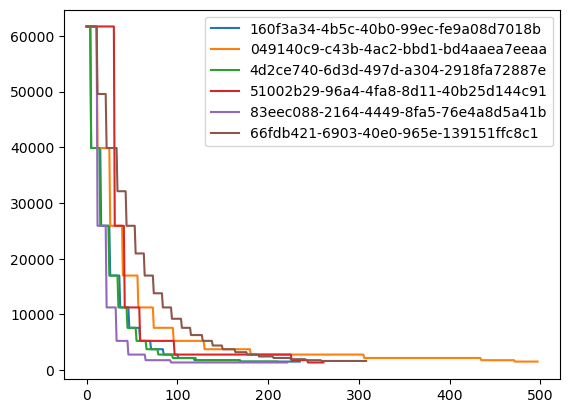

In [8]:
for i, experiement in experiments.iterrows():
    if i > 5:
        break
    plt.plot(experiement['history']['free_parameter_count'] - experiement['history']['masked_parameter_count'], 
             label=experiement['id'])
plt.legend()
plt.show()

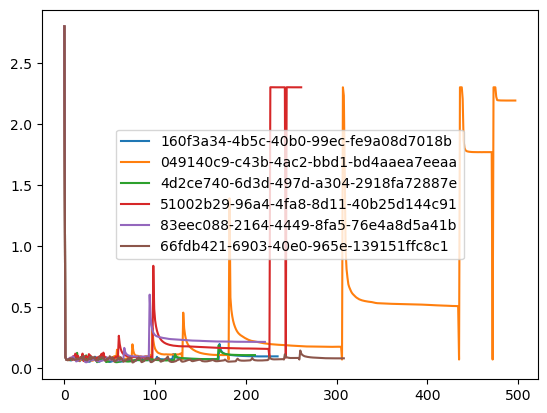

In [9]:
for i, experiement in experiments.iterrows():
    if i > 5:
        break
    plt.plot(experiement['history']['validation_loss'], 
             label=experiement['id'])
plt.legend()
plt.show()

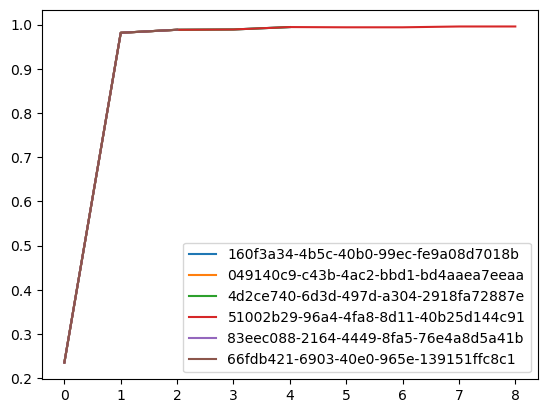

In [10]:
for i, experiement in experiments.iterrows():
    if i > 5:
        break
    plt.plot(experiement['history']['trained_cosine_similarity_extended'], 
             label=experiement['id'])
plt.legend()
plt.show()

In [11]:
studyID = parentIDs['id'][0]
print(f"Studying: {studyID}")
experiments = getExperiments(studyID)

Studying: 214b723d-0a13-413f-ae2d-9b508ab115a2


In [12]:
experiments.head(4)

,id,pruning_method,pruning_rate,rewind_epoch,random_seed,experiment_id,command,history
0,160f3a34-4b5c-40b0-99ec-fe9a08d7018b,MagnitudePruner,0.36,2,1705621050,109bde9a-7a56-bcd5-2452-5ab1be846f50,"{'type': 'Run', 'config_data_batch': 'lmc_mnis...",trained_loss retained masked_parameter_...
1,049140c9-c43b-4ac2-bbd1-bd4aaea7eeaa,RandomPruner,0.36,2,1705621050,148c24ee-a328-5297-aa0e-15c7c7bf6a0d,"{'type': 'Run', 'config_data_batch': 'lmc_mnis...",trained_loss retained masked_parameter_...
2,4d2ce740-6d3d-497d-a304-2918fa72887e,MagnitudePruner,0.36,4,1705621050,e367d334-2e01-240b-7d5b-dcb649adb1f0,"{'type': 'Run', 'config_data_batch': 'lmc_mnis...",trained_loss retained masked_parameter_...
3,51002b29-96a4-4fa8-8d11-40b25d144c91,RandomPruner,0.5904,8,1705621050,58d5e461-3c2e-e518-7642-1509a16361d2,"{'type': 'Run', 'config_data_batch': 'lmc_mnis...",trained_loss retained masked_parameter_...


In [13]:
experiments.iloc[0]['history'].head(3).columns

Index(['trained_loss', 'retained', 'masked_parameter_count',
       'validation_accuracy', 'train_loss', 'test_accuracy', 'test_ms',
       'trained_ms', 'fit_epoch', 'fit_number', 'epoch_startms_ms',
       'free_parameter_count', 'seed_number', 'epoch', 'test_loss',
       'validation_loss', 'trainms_ms', 'train_accuracy', 'trained_accuracy',
       'test_kullback_leibler_divergence_extended',
       'test_cosine_similarity_extended', 'train_categorical_hinge_extended',
       'trained_cosine_similarity_extended',
       'validation_categorical_hinge_extended',
       'trained_categorical_hinge_extended',
       'train_cosine_similarity_extended',
       'trained_kullback_leibler_divergence_extended',
       'test_categorical_hinge_extended',
       'train_kullback_leibler_divergence_extended',
       'validation_kullback_leibler_divergence_extended',
       'validation_cosine_similarity_extended'],
      dtype='object')

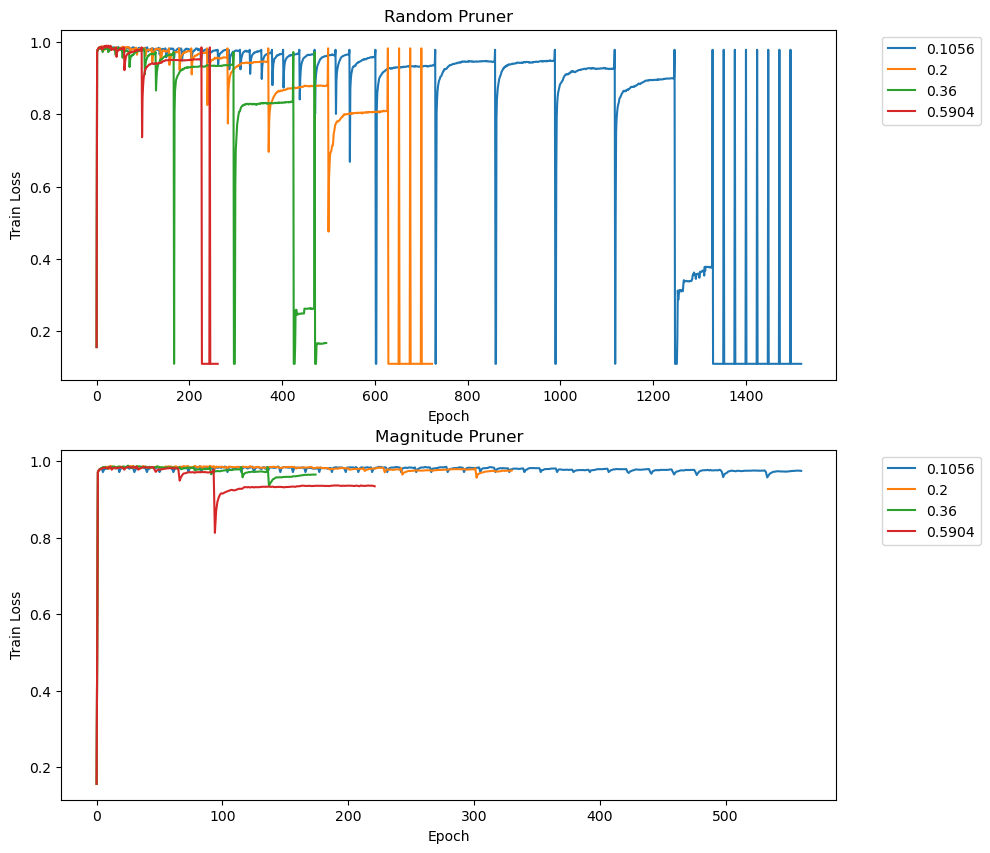

In [14]:
# make a 3x1 plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
Random_pruner = []
Magnitude_pruner = []
# sort the experiments by pruning rate
experiments = experiments.sort_values(by='pruning_rate')
for id, experiment in experiments.iterrows():
    history = experiment['history']
    plot = "validation_accuracy"
    if experiment['pruning_method'] == "RandomPruner":
        if not round(experiment['pruning_rate'],4) in Random_pruner:
            axs[0].plot(history[plot], label=round(experiment['pruning_rate'],4))
            Random_pruner.append(round(experiment['pruning_rate'],4))
    if experiment['pruning_method'] == "MagnitudePruner":
        if not round(experiment['pruning_rate'],4) in Magnitude_pruner:
            axs[1].plot(history[plot], label=round(experiment['pruning_rate'],4))
            Magnitude_pruner.append(round(experiment['pruning_rate'],4))

axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Train Loss")
axs[1].set_ylabel("Train Loss")
axs[0].set_title("Random Pruner")
axs[1].set_title("Magnitude Pruner")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
        
        